In [29]:
import numpy as np
import scipy.special as sp


In [30]:
def CarToSph(xyz):
    if len(xyz.shape) == 2:
        x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    elif len(xyz.shape) == 1:
        x, y, z = xyz[0], xyz[1], xyz[2]
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    return r, theta, phi


def SphToCar(r, theta, phi):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return x, y, z


In [31]:
N = 1000
particle = np.random.uniform(size=(N, 4))


In [32]:
eps = 10**-2
p = int(np.ceil(-np.log(eps)/np.log(3**0.5)))


In [33]:
level = int(np.ceil(np.log2(N)/3)) + 1
idx_particle = -np.ones(shape=(N, level, 3), dtype=np.int32)
for i in range(N):
    idx_particle[i, 0, :] = 0
    residu = particle[i, :3]
    for j in range(1, level):
        split = np.int32(residu > 0.5)
        idx_particle[i, j, :] = idx_particle[i, j-1, :]*2+split
        residu = 2*residu-split


In [34]:
def XYZToL(idx, level):
    n = 2**level
    return idx[2]*n*n+idx[1]*n+idx[0]


def LToXYZ(l, level):
    n = 2**level
    z = l//(n*n)
    y = (l-z*n*n)//n
    x = (l-z*n*n) % n
    return np.array([x, y, z])


In [35]:
LToXYZ(XYZToL([541, 342, 247], 10), 10)


array([541, 342, 247])

In [36]:
tree_idx = [[[] for j in range(8**i)] for i in range(level)]
for i in range(level):
    for j in range(N):
        tree_idx[i][XYZToL(idx_particle[j, i, :], i)].append(j)


In [37]:
def CellCenter(idx, level):
    return idx*2**(-level)+2**(-level-1)


In [38]:
def NeighboursRange(center_idx, center_level):
    return [np.maximum(0, center_idx[center_level, :]-1), np.minimum(2**center_level-1, center_idx[center_level, :]+1)]


def NeighboursChildRange(center_idx, center_level):
    return [np.maximum(0, 2*(center_idx[center_level, :]-1)), np.minimum(2**(center_level+1)-1, 2*center_idx[center_level, :]+3)]


In [67]:
def Y(m, n, theta, phi):
    y = np.sqrt(sp.factorial(n-abs(m))/sp.factorial(n+abs(m)))\
        * sp.lpmn(abs(m), n, np.cos(theta))[0][-1][n]
    y_real = y*np.cos(m*phi)
    y_image = y*np.sin(m*phi)
    return np.array([y_real, y_image])

A_coeff = np.zeros(shape=(100,100))
for n in range(99+1):
    for m in range(0, n+1):
        A_coeff[n,m] = np.sqrt(sp.factorial(n-abs(m))/sp.factorial(n+abs(m)))


def Ys(max_n, theta, phi):
    out = np.zeros(shape=(max_n, max_n, 2))
    Pmn = sp.lpmn(max_n-1, max_n-1, np.cos(theta))[0]
    out[:, :, 0] = A_coeff[:max_n,:max_n] * Pmn[:, :].T
    out[:, :, 1] = out[:, :, 0]
    for m in range(0, max_n):
        out[:, m, 0] *= np.cos(m*phi)  # Re part
        out[:, m, 1] *= np.sin(m*phi)  # Im part
    return out


def M(m, n, mass, relat_xyz):
    corr_sph = CarToSph(relat_xyz)
    sum = np.zeros(2)
    for k in range(mass.shape[0]):
        y = Y(-m, n, corr_sph[1][k], corr_sph[2][k])
        sum += mass[k]*corr_sph[0][k]**n * y
    return sum


def eval_phi(relat_xyz, M_coeff):
    total_n = M_coeff.shape[0] # The degree of P_mn
    corr_sph = CarToSph(relat_xyz)
    tot = 0
    y = Ys(total_n, corr_sph[1], corr_sph[2])
    for n in range(total_n):
        y[n, :, :] /= corr_sph[0]**(n+1)
    #T = M_coeff[:, :, 0]*y[:, :, 0] - M_coeff[:, :, 1]*y[:, :, 1] # Complex Conjugate to Real
    #T[:,1:] *= 2 # Count for -n<m<0
    for n in range(total_n):
        for m in range(0, n+1):  # range(-n, n+1):
            if m == 0:
                tot += ComplexMultiply(M_coeff[n, m, :], y[n, m, :])[0]
            else:
                tot += 2 * ComplexMultiply(M_coeff[n, m, :], y[n, m, :])[0]
    return  tot #np.sum(T)


def ComplexMultiply(A, B):
    return np.array([A[0]*B[0]-A[1]*B[1], A[0]*B[1]+A[1]*B[0]])


In [63]:
total_n = M_coeff.shape[0] # The degree of P_mn
corr_sph = CarToSph(relat_xyz)
y = Ys(total_n, corr_sph[1], corr_sph[2])
for n in range(total_n):
    y[n, :, :] /= corr_sph[0]**(n+1)
T = M_coeff[:, :, 0]*y[:, :, 0] - M_coeff[:, :, 1]*y[:, :, 1] # Complex Conjugate to Real
T[:,1:] *= 2 # Count for -n<m<0

In [66]:
y[2,1,0]

-1.5162784634191364

In [60]:
eval_phi(relat_xyz, M_coeff)

10.76337475950849

In [54]:
# O(NlogN) scheme

M_tree = [np.zeros(shape=(8**i, p+1, p+1, 2)) for i in range(level)]
for i in range(level):
    for j in range(8**i):
        idx = np.array(tree_idx[i][j])
        if len(idx) == 0:
            continue
        XYZ = particle[idx, :3] - CellCenter(LToXYZ(j, i), i)
        mass = particle[idx, 3]
        for n in range(p+1):
            for m in range(0, n+1):
                M_tree[i][j, n, m, :] = M(m, n, mass, XYZ)


In [68]:
potential = np.zeros(N)
for i in range(N):
    incl = NeighboursRange(idx_particle[i, :, :], level-1)  # Direct evaluate
    for x in range(incl[0][0], incl[1][0]+1):
        for y in range(incl[0][1], incl[1][1]+1):
            for z in range(incl[0][2], incl[1][2]+1):
                index = np.array(tree_idx[level-1][XYZToL([x, y, z], level-1)])
                if len(idx) == 0:
                    continue
                for id in index:
                    if id == i:
                        continue
                    dXYZ = particle[id, :3] - particle[i, :3]
                    r = np.sqrt(np.sum(dXYZ**2))
                    potential[i] += particle[id, 3]/r
    for j in range(2, level):
        # Range of parent's neighbours
        incl = NeighboursChildRange(idx_particle[i, :, :], j-1)
        excl = NeighboursRange(idx_particle[i, :, :], j)  # Range of neighbours
        for x in range(incl[0][0], incl[1][0]+1):
            for y in range(incl[0][1], incl[1][1]+1):
                for z in range(incl[0][2], incl[1][2]+1):
                    if excl[0][0] <= x and excl[1][0] >= x and excl[0][1] <= y and excl[1][1] >= y and excl[0][2] <= z and excl[1][2] >= z:
                        continue
                    RelativeXYZ = particle[i, :3] - CellCenter(np.array([x, y, z]), j)
                    potential[i] += eval_phi(RelativeXYZ, M_tree[j][XYZToL([x, y, z], j), :, :, :])


In [16]:
potential_direct = np.zeros(N)
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        dXYZ = particle[j, :3] - particle[i, :3]
        r = np.sqrt(np.sum(dXYZ**2))
        potential_direct[i] += particle[j, 3]/r


In [17]:
import matplotlib.pyplot as plt


Text(0, 0.5, 'Direct-N')

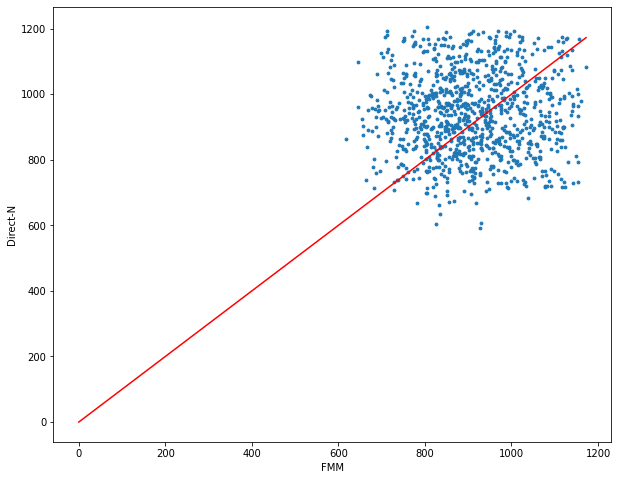

In [69]:
plt.figure(figsize=(10, 8))
plt.plot([0, max(potential)], [0, max(potential)], color='r')
plt.scatter(potential, potential_direct, s=8)
plt.xlabel("FMM")
plt.ylabel("Direct-N")
